# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, Add
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

#### Limit three class preprocessing

In [6]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500,)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

8.0    5000
7.0    5000
6.0    5000
5.0    5000
3.0    5000
1.0    5000
0.0    5000
9.0    2500
4.0    2500
2.0    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

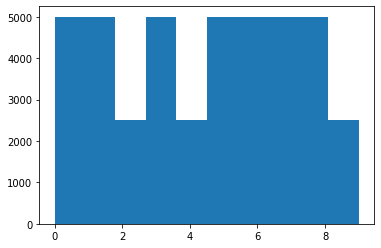

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

In [10]:
# train test split
# stratify y label
x_train_removed, x_valid_removed, y_train_removed, y_valid_removed = train_test_split(x_train_removed, y_train_removed, 
                                                                      test_size=0.3, random_state=42, stratify=y_train_removed)

In [11]:
print(x_train_removed.shape)
print(y_train_removed.shape)
print(x_valid_removed.shape)
print(y_valid_removed.shape)

(29750, 32, 32, 3)
(29750,)
(12750, 32, 32, 3)
(12750,)


In [12]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

8.0    3500
7.0    3500
6.0    3500
5.0    3500
3.0    3500
1.0    3500
0.0    3500
9.0    1750
4.0    1750
2.0    1750
dtype: int64


In [13]:
df = pd.DataFrame(y_valid_removed.flatten())
print(df.value_counts())
del df

8.0    1500
7.0    1500
6.0    1500
5.0    1500
3.0    1500
1.0    1500
0.0    1500
9.0     750
4.0     750
2.0     750
dtype: int64


## AutoEncoder

#### Load AE models weight

In [14]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [15]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN Ver 2 change 6 layer -> 12 layer

In [16]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output) # 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(x) # 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(x) # 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 7
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 8,8,128

    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 8
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 9
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 10
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x) # 11
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x) # 12

    return Model(input_img, y)

model01 = create_StackedAE01_CNN01_model(stack01.encoder)
model01.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)       

#### Train without data augumentation 

In [18]:
# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

# Hyperparmeter Optimization
def objective1(trial):
    print("Optimize Start")

    # batch size
    batch_size = trial.suggest_categorical('batchsize', [32, 64, 128]) # 32 or 64 or 128
    
    # optimizer
    optimizer = trial.suggest_categorical("optimizer", ['adam', 'sgd', 'rmsprop']) # Adam or SGD or RMsprop

    model01.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

    history = model01.fit(x_train_removed, y_train_removed_onehot,
                          batch_size=batch_size,
                          epochs=400,
                          verbose=1,
                          validation_data=(x_valid_removed, y_valid_removed_onehot),
                          callbacks=[es_cb],
                          shuffle=True)
    return min(history.history["val_loss"]) # get min loss
    
# create study object
study1 = optuna.create_study()

# optimization
study1.optimize(objective1, n_trials=10)

[I 2021-03-09 21:53:30,327] A new study created in memory with name: no-name-65b1555d-07ae-4b11-8e95-db0ee27155e8


Optimize Start
Epoch 1/400
465/465 [==============================] - 8s 18ms/step - loss: 1.5728 - accuracy: 0.4343 - val_loss: 1.7809 - val_accuracy: 0.3720
Epoch 2/400
465/465 [==============================] - 8s 16ms/step - loss: 1.2354 - accuracy: 0.5595 - val_loss: 1.4092 - val_accuracy: 0.5277
Epoch 3/400
465/465 [==============================] - 8s 16ms/step - loss: 1.0506 - accuracy: 0.6273 - val_loss: 1.1694 - val_accuracy: 0.5852
Epoch 4/400
465/465 [==============================] - 8s 16ms/step - loss: 0.8980 - accuracy: 0.6839 - val_loss: 1.1933 - val_accuracy: 0.6018
Epoch 5/400
465/465 [==============================] - 8s 17ms/step - loss: 0.7661 - accuracy: 0.7318 - val_loss: 1.0306 - val_accuracy: 0.6392
Epoch 6/400
465/465 [==============================] - 8s 17ms/step - loss: 0.6437 - accuracy: 0.7795 - val_loss: 1.0530 - val_accuracy: 0.6483
Epoch 7/400
465/465 [==============================] - 8s 17ms/step - loss: 0.5252 - accuracy: 0.8221 - val_loss: 1.0071 

[I 2021-03-09 21:55:05,593] Trial 0 finished with value: 0.9774738550186157 and parameters: {'batchsize': 64, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9774738550186157.


Epoch 00012: early stopping
Optimize Start
Epoch 1/400
465/465 [==============================] - 8s 17ms/step - loss: 1.0290 - accuracy: 0.6454 - val_loss: 1.3868 - val_accuracy: 0.5570
Epoch 2/400
465/465 [==============================] - 8s 17ms/step - loss: 0.7321 - accuracy: 0.7480 - val_loss: 0.9054 - val_accuracy: 0.6969
Epoch 3/400
465/465 [==============================] - 8s 17ms/step - loss: 0.5762 - accuracy: 0.8027 - val_loss: 1.0595 - val_accuracy: 0.6631
Epoch 4/400
465/465 [==============================] - 8s 17ms/step - loss: 0.4665 - accuracy: 0.8379 - val_loss: 0.6972 - val_accuracy: 0.7687
Epoch 5/400
465/465 [==============================] - 8s 17ms/step - loss: 0.3747 - accuracy: 0.8703 - val_loss: 0.6822 - val_accuracy: 0.7791
Epoch 6/400
465/465 [==============================] - 8s 17ms/step - loss: 0.2983 - accuracy: 0.8946 - val_loss: 0.7218 - val_accuracy: 0.7782
Epoch 7/400
465/465 [==============================] - 8s 17ms/step - loss: 0.2314 - accuracy

[I 2021-03-09 21:56:25,730] Trial 1 finished with value: 0.6814756989479065 and parameters: {'batchsize': 64, 'optimizer': 'adam'}. Best is trial 1 with value: 0.6814756989479065.


Epoch 00010: early stopping
Optimize Start
Epoch 1/400
465/465 [==============================] - 9s 19ms/step - loss: 0.1289 - accuracy: 0.9554 - val_loss: 0.9211 - val_accuracy: 0.7816
Epoch 2/400
465/465 [==============================] - 9s 19ms/step - loss: 0.1013 - accuracy: 0.9658 - val_loss: 0.7298 - val_accuracy: 0.8266
Epoch 3/400
465/465 [==============================] - 9s 18ms/step - loss: 0.0917 - accuracy: 0.9683 - val_loss: 0.9808 - val_accuracy: 0.7901
Epoch 4/400
465/465 [==============================] - 9s 19ms/step - loss: 0.0843 - accuracy: 0.9711 - val_loss: 0.8142 - val_accuracy: 0.8218
Epoch 5/400
465/465 [==============================] - 9s 19ms/step - loss: 0.0718 - accuracy: 0.9751 - val_loss: 0.8808 - val_accuracy: 0.8093


[I 2021-03-09 21:57:11,009] Trial 2 finished with value: 0.7298377156257629 and parameters: {'batchsize': 64, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.6814756989479065.


Epoch 00005: early stopping
Optimize Start
Epoch 1/400
233/233 [==============================] - 8s 33ms/step - loss: 0.0403 - accuracy: 0.9859 - val_loss: 1.0901 - val_accuracy: 0.7893
Epoch 2/400
233/233 [==============================] - 7s 30ms/step - loss: 0.0263 - accuracy: 0.9911 - val_loss: 0.9961 - val_accuracy: 0.8115
Epoch 3/400
233/233 [==============================] - 7s 30ms/step - loss: 0.0275 - accuracy: 0.9907 - val_loss: 1.1099 - val_accuracy: 0.8050
Epoch 4/400
233/233 [==============================] - 7s 30ms/step - loss: 0.0265 - accuracy: 0.9910 - val_loss: 1.1809 - val_accuracy: 0.8033
Epoch 5/400
233/233 [==============================] - 7s 30ms/step - loss: 0.0220 - accuracy: 0.9924 - val_loss: 0.9928 - val_accuracy: 0.8288
Epoch 6/400
233/233 [==============================] - 7s 30ms/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 1.0829 - val_accuracy: 0.8127
Epoch 7/400
233/233 [==============================] - 7s 30ms/step - loss: 0.0241 - accuracy

[I 2021-03-09 21:58:10,376] Trial 3 finished with value: 0.9928146600723267 and parameters: {'batchsize': 128, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.6814756989479065.


Epoch 00008: early stopping
Optimize Start
Epoch 1/400
465/465 [==============================] - 9s 19ms/step - loss: 0.0542 - accuracy: 0.9815 - val_loss: 1.0299 - val_accuracy: 0.8206
Epoch 2/400
465/465 [==============================] - 9s 19ms/step - loss: 0.0515 - accuracy: 0.9826 - val_loss: 1.2034 - val_accuracy: 0.8031
Epoch 3/400
465/465 [==============================] - 9s 19ms/step - loss: 0.0512 - accuracy: 0.9831 - val_loss: 1.2407 - val_accuracy: 0.7941
Epoch 4/400
465/465 [==============================] - 9s 19ms/step - loss: 0.0447 - accuracy: 0.9851 - val_loss: 1.1389 - val_accuracy: 0.8148


[I 2021-03-09 21:58:47,086] Trial 4 finished with value: 1.0298796892166138 and parameters: {'batchsize': 64, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.6814756989479065.


Epoch 00004: early stopping
Optimize Start
Epoch 1/400
233/233 [==============================] - 7s 31ms/step - loss: 0.0280 - accuracy: 0.9909 - val_loss: 0.9157 - val_accuracy: 0.8322
Epoch 2/400
233/233 [==============================] - 7s 29ms/step - loss: 0.0201 - accuracy: 0.9930 - val_loss: 1.0617 - val_accuracy: 0.8273
Epoch 3/400
233/233 [==============================] - 7s 29ms/step - loss: 0.0180 - accuracy: 0.9941 - val_loss: 1.0666 - val_accuracy: 0.8205
Epoch 4/400
233/233 [==============================] - 7s 29ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 1.0258 - val_accuracy: 0.8261


[I 2021-03-09 21:59:15,613] Trial 5 finished with value: 0.9157230257987976 and parameters: {'batchsize': 128, 'optimizer': 'adam'}. Best is trial 1 with value: 0.6814756989479065.


Epoch 00004: early stopping
Optimize Start
Epoch 1/400
930/930 [==============================] - 10s 11ms/step - loss: 0.0233 - accuracy: 0.9923 - val_loss: 0.8774 - val_accuracy: 0.8511
Epoch 2/400
930/930 [==============================] - 10s 11ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.8632 - val_accuracy: 0.8542
Epoch 3/400
930/930 [==============================] - 10s 11ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.8464 - val_accuracy: 0.8554
Epoch 4/400
930/930 [==============================] - 10s 11ms/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 0.8436 - val_accuracy: 0.8559
Epoch 5/400
930/930 [==============================] - 10s 11ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.8403 - val_accuracy: 0.8572
Epoch 6/400
930/930 [==============================] - 10s 11ms/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.8400 - val_accuracy: 0.8564
Epoch 7/400
930/930 [==============================] - 10s 11ms/step - loss: 0.0082 - a

[I 2021-03-09 22:00:47,283] Trial 6 finished with value: 0.8399927020072937 and parameters: {'batchsize': 32, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.6814756989479065.


Epoch 00009: early stopping
Optimize Start
Epoch 1/400
465/465 [==============================] - 8s 17ms/step - loss: 0.0460 - accuracy: 0.9845 - val_loss: 1.0249 - val_accuracy: 0.8180
Epoch 2/400
465/465 [==============================] - 8s 17ms/step - loss: 0.0419 - accuracy: 0.9859 - val_loss: 0.9340 - val_accuracy: 0.8121
Epoch 3/400
465/465 [==============================] - 8s 17ms/step - loss: 0.0362 - accuracy: 0.9876 - val_loss: 0.9577 - val_accuracy: 0.8264
Epoch 4/400
465/465 [==============================] - 8s 17ms/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 1.0545 - val_accuracy: 0.8144
Epoch 5/400
465/465 [==============================] - 8s 17ms/step - loss: 0.0305 - accuracy: 0.9887 - val_loss: 1.0503 - val_accuracy: 0.8086


[I 2021-03-09 22:01:28,071] Trial 7 finished with value: 0.9340168237686157 and parameters: {'batchsize': 64, 'optimizer': 'adam'}. Best is trial 1 with value: 0.6814756989479065.


Epoch 00005: early stopping
Optimize Start
Epoch 1/400
465/465 [==============================] - 8s 17ms/step - loss: 0.0227 - accuracy: 0.9925 - val_loss: 0.8391 - val_accuracy: 0.8424
Epoch 2/400
465/465 [==============================] - 8s 17ms/step - loss: 0.0152 - accuracy: 0.9947 - val_loss: 0.8234 - val_accuracy: 0.8458
Epoch 3/400
465/465 [==============================] - 10s 20ms/step - loss: 0.0123 - accuracy: 0.9959 - val_loss: 0.8089 - val_accuracy: 0.8469
Epoch 4/400
465/465 [==============================] - 8s 18ms/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.8045 - val_accuracy: 0.8482
Epoch 5/400
465/465 [==============================] - 9s 20ms/step - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.8018 - val_accuracy: 0.8486
Epoch 6/400
465/465 [==============================] - 8s 17ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.8008 - val_accuracy: 0.8499
Epoch 7/400
465/465 [==============================] - 8s 17ms/step - loss: 0.0078 - accurac

[I 2021-03-09 22:04:09,532] Trial 8 finished with value: 0.7835516333580017 and parameters: {'batchsize': 64, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.6814756989479065.


Epoch 00020: early stopping
Optimize Start
Epoch 1/400
465/465 [==============================] - 9s 19ms/step - loss: 0.0234 - accuracy: 0.9915 - val_loss: 1.1445 - val_accuracy: 0.8285
Epoch 2/400
465/465 [==============================] - 9s 19ms/step - loss: 0.0246 - accuracy: 0.9918 - val_loss: 1.2265 - val_accuracy: 0.8273
Epoch 3/400
465/465 [==============================] - 9s 18ms/step - loss: 0.0250 - accuracy: 0.9910 - val_loss: 1.2213 - val_accuracy: 0.8213
Epoch 4/400
465/465 [==============================] - 9s 18ms/step - loss: 0.0234 - accuracy: 0.9921 - val_loss: 1.3889 - val_accuracy: 0.7991


[I 2021-03-09 22:04:46,419] Trial 9 finished with value: 1.1445196866989136 and parameters: {'batchsize': 64, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.6814756989479065.


Epoch 00004: early stopping


In [19]:
print(study1.best_params)

{'batchsize': 64, 'optimizer': 'adam'}


In [ ]:
%%time

model01 = create_StackedAE01_CNN01_model(stack01.encoder)

optimizer = Adam() # best param
model01.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

# train
saveDir = "../models/CNN/"

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_029_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model01_history = model01.fit(x_train_removed, y_train_removed_onehot,
                      batch_size=64, # best param
                      epochs=400,
                      verbose=1,
                      validation_data=(x_valid_removed, y_valid_removed_onehot),
                      callbacks=[es_cb, cp_cb],
                      shuffle=True)

Epoch 1/400
462/465 [============================>.] - ETA: 0s - loss: 1.4081 - accuracy: 0.4949
Epoch 00001: val_loss improved from inf to 1.33594, saving model to ../models/CNN\Model_029_Best.hdf5
465/465 [==============================] - 8s 18ms/step - loss: 1.4065 - accuracy: 0.4955 - val_loss: 1.3359 - val_accuracy: 0.5210
Epoch 2/400
464/465 [============================>.] - ETA: 0s - loss: 0.9830 - accuracy: 0.6565
Epoch 00002: val_loss improved from 1.33594 to 1.01842, saving model to ../models/CNN\Model_029_Best.hdf5
465/465 [==============================] - 8s 17ms/step - loss: 0.9828 - accuracy: 0.6564 - val_loss: 1.0184 - val_accuracy: 0.6393
Epoch 3/400
465/465 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.7403
Epoch 00003: val_loss improved from 1.01842 to 0.79371, saving model to ../models/CNN\Model_029_Best.hdf5
465/465 [==============================] - 9s 20ms/step - loss: 0.7491 - accuracy: 0.7403 - val_loss: 0.7937 - val_accuracy: 0.7312

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

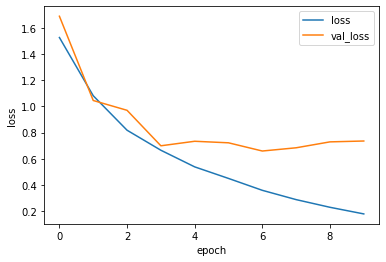

<Figure size 432x288 with 0 Axes>

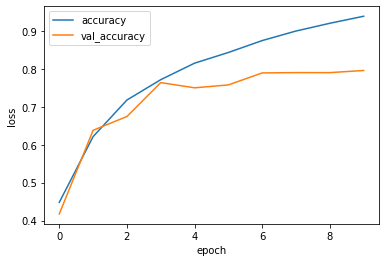

In [19]:
# plot training
mdoel01_hist_df = pd.DataFrame(model01_history.history)

plt.figure()
mdoel01_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
mdoel01_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [20]:
model01.load_weights('../models/CNN/Model_029_Best.hdf5')
model01.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 1s 4ms/step - loss: 0.7081 - accuracy: 0.7813


[0.7081124186515808, 0.7813000082969666]

In [21]:
y_pred = model01.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1000
           1       0.93      0.78      0.85      1000
           2       0.78      0.64      0.70      1000
           3       0.58      0.71      0.64      1000
           4       0.87      0.59      0.70      1000
           5       0.72      0.74      0.73      1000
           6       0.82      0.89      0.85      1000
           7       0.83      0.83      0.83      1000
           8       0.93      0.85      0.88      1000
           9       0.70      0.95      0.81      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



#### Create Model AE to CNN Ver 3 change 6 layer -> 15 layer

In [61]:
def create_StackedAE01_CNN02_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output) # 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(x) # 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(x) # 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x) # 7
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 8,8,128

    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 8
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 9
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3),padding = "same",activation= "relu")(x) # 10
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512,(3,3),padding = "same",activation= "relu")(x) # 11
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512,(3,3),padding = "same",activation= "relu")(x) # 12
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512,(3,3),padding = "same",activation= "relu")(x) # 13
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 4,4,256
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x) # 14
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x) # 15

    return Model(input_img, y)

model02 = create_StackedAE01_CNN02_model(stack01.encoder)
model02.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_114 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
activation_114 (Activation)  (None, 32, 32, 64)      

In [29]:
adam = Adam() # defalut
model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

In [30]:
%%time

# train
saveDir = "../models/CNN/"

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_026_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model02_history = model02.fit(x_train_removed, y_train_removed_onehot,
                      batch_size=32,
                      epochs=400,
                      verbose=1,
                      validation_data=(x_valid_removed, y_valid_removed_onehot),
                      callbacks=[es_cb, cp_cb],
                      shuffle=True)

Epoch 1/400
930/930 [==============================] - ETA: 0s - loss: 1.6140 - accuracy: 0.4139
Epoch 00001: val_loss improved from inf to 1.58718, saving model to ../models/CNN\Model_026_Best.hdf5
930/930 [==============================] - 16s 17ms/step - loss: 1.6140 - accuracy: 0.4139 - val_loss: 1.5872 - val_accuracy: 0.4453
Epoch 2/400
928/930 [============================>.] - ETA: 0s - loss: 1.2291 - accuracy: 0.5691
Epoch 00002: val_loss improved from 1.58718 to 1.29621, saving model to ../models/CNN\Model_026_Best.hdf5
930/930 [==============================] - 16s 17ms/step - loss: 1.2290 - accuracy: 0.5692 - val_loss: 1.2962 - val_accuracy: 0.5318
Epoch 3/400
928/930 [============================>.] - ETA: 0s - loss: 1.0012 - accuracy: 0.6535
Epoch 00003: val_loss improved from 1.29621 to 1.07891, saving model to ../models/CNN\Model_026_Best.hdf5
930/930 [==============================] - 16s 17ms/step - loss: 1.0012 - accuracy: 0.6535 - val_loss: 1.0789 - val_accuracy: 0.6

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

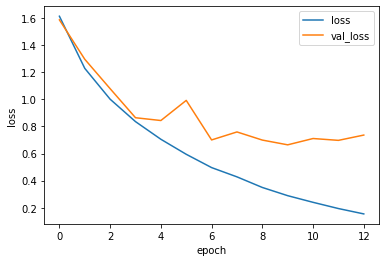

<Figure size 432x288 with 0 Axes>

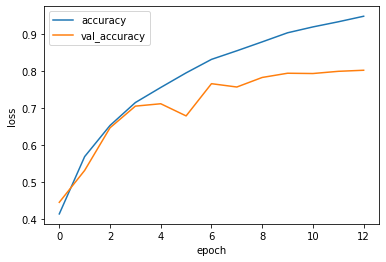

In [31]:
# plot training
model02_hist_df = pd.DataFrame(model02_history.history)

plt.figure()
model02_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
model02_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [32]:
model02.load_weights('../models/CNN/Model_026_Best.hdf5')
model02.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 2s 5ms/step - loss: 0.7022 - accuracy: 0.7844


[0.7022432684898376, 0.7843999862670898]

In [33]:
y_pred = model02.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1000
           1       0.95      0.85      0.90      1000
           2       0.83      0.54      0.65      1000
           3       0.58      0.73      0.65      1000
           4       0.76      0.73      0.75      1000
           5       0.73      0.72      0.73      1000
           6       0.80      0.85      0.82      1000
           7       0.73      0.88      0.80      1000
           8       0.93      0.81      0.87      1000
           9       0.86      0.88      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.80      0.78      0.78     10000
weighted avg       0.80      0.78      0.78     10000



#### Create Model AE to CNN Ver 4 change 6 layer -> 15 layer like ResNet

In [55]:
def create_StackedAE01_CNN03_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(5,5),padding = "same",activation= "relu")(output) # 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D(pool_size=(2, 2))(x) # 16,16,64
    
    x2 = Conv2D(64,(3,3),padding = "same",activation= "relu")(x1) # 3
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(64,(3,3),padding = "same",activation= "relu")(x2) # 4
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    
    x3 = Add()([x1, x2])
    
    x4 = Conv2D(64,(3,3),padding = "same",activation= "relu")(x3) # 5
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(64,(3,3),padding = "same",activation= "relu")(x4) # 6
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)
    
    x5 = Add()([x3, x4])

    x6 = Conv2D(128,(3,3),padding = "same",activation= "relu")(x5) # 7
    x6 = BatchNormalization()(x6)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(128,(3,3),padding = "same",activation= "relu")(x6) # 8
    x6 = BatchNormalization()(x6)
    x6 = Activation('relu')(x6)
    
    x5 = Conv2D(128,(1,1),padding = "same",activation= "relu")(x6)
    x7 = Add()([x5, x6])
               
    x8 = Conv2D(128,(3,3),padding = "same",activation= "relu")(x7) # 9
    x8 = BatchNormalization()(x8)
    x8 = Activation('relu')(x8)
    x8 = Conv2D(128,(3,3),padding = "same",activation= "relu")(x8) # 10
    x8 = BatchNormalization()(x8)
    x8 = Activation('relu')(x8)
    
    x9 = Add()([x7, x8])
               
    x10 = Conv2D(256,(3,3),padding = "same",activation= "relu")(x9) # 11
    x10 = BatchNormalization()(x10)
    x10 = Activation('relu')(x10)
    x10 = Conv2D(256,(3,3),padding = "same",activation= "relu")(x10) # 12
    x10 = BatchNormalization()(x10)
    x10 = Activation('relu')(x10)
    
    x9 = Conv2D(256,(1,1),padding = "same",activation= "relu")(x9)
    x11 = Add()([x9, x10])
    
    x12 = Conv2D(256,(3,3),padding = "same",activation= "relu")(x11) # 13
    x12 = BatchNormalization()(x12)
    x12 = Activation('relu')(x12)
    x12 = Conv2D(256,(3,3),padding = "same",activation= "relu")(x12) # 14
    x12 = BatchNormalization()(x12)
    x12 = Activation('relu')(x12)
                
    x13 = Add()([x11, x12])
    x13 = MaxPooling2D(pool_size=(2, 2))(x13) # 8, 8 256         
    x13 = GlobalAveragePooling2D()(x13)
    x14 = Dense(256)(x13) # 15
    x14 = BatchNormalization()(x14)
    x14 = Activation("relu")(x14)
    y = Dense(10,activation = "softmax")(x14) # 16

    return Model(input_img, y)

model03 = create_StackedAE01_CNN03_model(stack01.encoder)
model03.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Dense_AE01_1 (Conv2D)           (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
BN_AE01_1 (BatchNormalization)  (None, 32, 32, 64)   256         Dense_AE01_1[0][0]               
__________________________________________________________________________________________________
Relu_AE01_1 (Activation)        (None, 32, 32, 64)   0           BN_AE01_1[0][0]                  
______________________________________________________________________________________

In [56]:
adam = Adam() # defalut
model03.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

In [57]:
%%time

# train
saveDir = "../models/CNN/"

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_027_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model03_history = model03.fit(x_train_removed, y_train_removed_onehot,
                      batch_size=32,
                      epochs=400,
                      verbose=1,
                      validation_data=(x_valid_removed, y_valid_removed_onehot),
                      callbacks=[es_cb, cp_cb],
                      shuffle=True)

Epoch 1/400
930/930 [==============================] - ETA: 0s - loss: 1.5123 - accuracy: 0.4533
Epoch 00001: val_loss improved from inf to 1.47789, saving model to ../models/CNN\Model_027_Best.hdf5
930/930 [==============================] - 17s 18ms/step - loss: 1.5123 - accuracy: 0.4533 - val_loss: 1.4779 - val_accuracy: 0.4881
Epoch 2/400
930/930 [==============================] - ETA: 0s - loss: 1.1525 - accuracy: 0.5918
Epoch 00002: val_loss improved from 1.47789 to 1.17334, saving model to ../models/CNN\Model_027_Best.hdf5
930/930 [==============================] - 17s 18ms/step - loss: 1.1525 - accuracy: 0.5918 - val_loss: 1.1733 - val_accuracy: 0.5899
Epoch 3/400
928/930 [============================>.] - ETA: 0s - loss: 0.9430 - accuracy: 0.6690
Epoch 00003: val_loss improved from 1.17334 to 1.00646, saving model to ../models/CNN\Model_027_Best.hdf5
930/930 [==============================] - 17s 18ms/step - loss: 0.9425 - accuracy: 0.6691 - val_loss: 1.0065 - val_accuracy: 0.6

In [58]:
model03.load_weights('../models/CNN/Model_027_Best.hdf5')
model03.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 2s 6ms/step - loss: 0.7719 - accuracy: 0.7524


[0.7718943953514099, 0.7523999810218811]

In [59]:
y_pred = model03.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1000
           1       0.98      0.67      0.79      1000
           2       0.69      0.67      0.68      1000
           3       0.63      0.59      0.61      1000
           4       0.75      0.72      0.74      1000
           5       0.73      0.62      0.67      1000
           6       0.70      0.90      0.78      1000
           7       0.69      0.86      0.77      1000
           8       0.76      0.94      0.84      1000
           9       0.83      0.81      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



#### Train with data augumentation & Ver2 CNN model

In [69]:
encoder = stack01.encoder
encoder.trainable = False
model01 = create_StackedAE01_CNN01_model(encoder) # transfer learning

adam = Adam() # defalut
model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

In [ ]:
%%time

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_028_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     shear_range=0.2,
    horizontal_flip=True,
#     vertical_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    zoom_range=0.1
#     channel_shift_range=0.2
    )

batch_size = 32
train_datagenerator = train_datagen.flow(x_train_removed, y_train_removed_onehot, batch_size)
valid_datagenerator = ImageDataGenerator().flow(x_valid_removed, y_valid_removed_onehot, batch_size)

model01_history = model01.fit_generator(train_datagenerator,
                              steps_per_epoch=int(len(x_train_removed)//batch_size),
                              epochs=400,
                              validation_data=valid_datagenerator,
                              validation_steps=int(len(x_valid_removed)//batch_size),
                              verbose=1,
                              shuffle=True,
                              callbacks=[es_cb, cp_cb])

Epoch 1/400
929/929 [==============================] - ETA: 0s - loss: 1.6518 - accuracy: 0.4050
Epoch 00001: val_loss improved from inf to 1.62255, saving model to ../models/CNN\Model_028_Best.hdf5
929/929 [==============================] - 16s 17ms/step - loss: 1.6518 - accuracy: 0.4050 - val_loss: 1.6226 - val_accuracy: 0.4530
Epoch 2/400
929/929 [==============================] - ETA: 0s - loss: 1.2872 - accuracy: 0.5403
Epoch 00002: val_loss improved from 1.62255 to 1.24713, saving model to ../models/CNN\Model_028_Best.hdf5
929/929 [==============================] - 16s 17ms/step - loss: 1.2872 - accuracy: 0.5403 - val_loss: 1.2471 - val_accuracy: 0.5841
Epoch 3/400
929/929 [==============================] - ETA: 0s - loss: 1.0598 - accuracy: 0.6309
Epoch 00003: val_loss improved from 1.24713 to 1.00119, saving model to ../models/CNN\Model_028_Best.hdf5
929/929 [==============================] - 16s 17ms/step - loss: 1.0598 - accuracy: 0.6309 - val_loss: 1.0012 - val_accuracy: 0.6

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

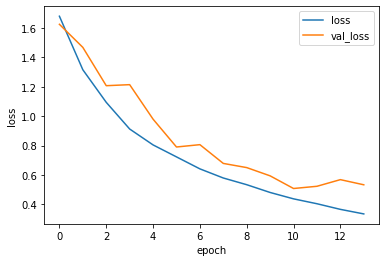

<Figure size 432x288 with 0 Axes>

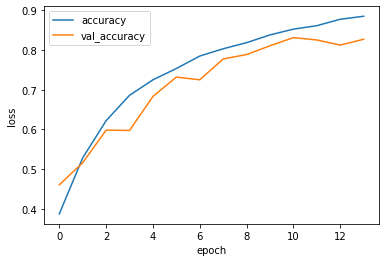

In [65]:
# plot training
model01_hist_df = pd.DataFrame(model01_history.history)

plt.figure()
model01_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
model01_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [66]:
model01.load_weights('../models/CNN/Model_028_Best.hdf5')
model01.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 2s 5ms/step - loss: 0.5633 - accuracy: 0.8136


[0.5633417963981628, 0.8136000037193298]

In [67]:
y_pred = model01.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1000
           1       0.92      0.92      0.92      1000
           2       0.86      0.57      0.68      1000
           3       0.68      0.69      0.69      1000
           4       0.79      0.78      0.78      1000
           5       0.80      0.74      0.77      1000
           6       0.81      0.88      0.85      1000
           7       0.80      0.85      0.83      1000
           8       0.86      0.90      0.88      1000
           9       0.89      0.88      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

